***FCIM.FIA - Fundamentals of Artificial Intelligence***

> **Lab 5:** *Processing Images with OpenCV and CNNs* \\
> **Performed by:** *Bajenov Sevastian*, group *FAF-213* \\
> **Verified by:** Elena Graur, asist. univ.

## Imports and Utils

Create a virtual environment, install all the necessary dependencies so that you can run the notebook using your virtual environment as a kernel.

In [1]:
# pip install -r requirements.txt

## Task 1

In this laboratory work the main task was to train different AI models to perform binary classification of an image dataset. The first task, however, is more of an introduction into the `opencv` module and its practical applications. They are mainly related to image manipulation, like, for instance, image blurring and sharpening.

`Image blurring` is achieved by convolving the image with a low-pass filter kernel. It is useful for removing noise. It actually removes high frequency content (eg: noise, edges) from the image. There are basically 3 ways to blur an image using opencv:
* `Averaging` - convolves an image with a normalized box filter. It simply takes the average of all the pixels under the kernel area and replaces the central element.
* `Gaussian Blurring` - instead of using a box filter, a Gaussian kernel is used. It is necessary to specify the width and height of the kernel which should be positive and odd, but also should specify the standard deviation in the X and Y directions.
* `Median Blurring` - takes the median of all the pixels under the kernel area and the central element is replaced with this median value. This is highly effective against salt-and-pepper noise in an image.

I decided to choose the first option by applying `cv2.blur()` function to the image. Moreover, it is important not to forget to change the color space of the image after processing it using opencv from BGR to RGB. The result of the blurring operation is presented further.

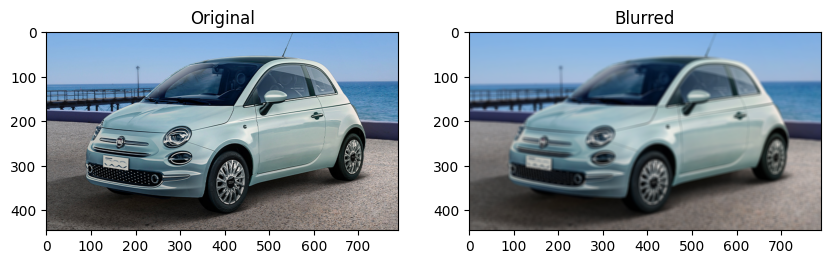

In [11]:
import cv2 as cv
import matplotlib.pyplot as plt


def blur_image(image_path, blur_kernel_size=(7, 7)):
    image = cv.imread(image_path)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    blur = cv.blur(image, blur_kernel_size)
    blur_rgb = cv.cvtColor(blur, cv.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('Original')

    plt.subplot(1, 2, 2)
    plt.imshow(blur_rgb)
    plt.title('Blurred')
    plt.show()

blur_image('example_images/fiat.jpg')

Now, it is time to discuss `image sharpening`. It is a technique used to enhance the edges and fine details in an image. It involves increasing the contrast between adjacent pixels, making the image appear more defined and crisp. Sharpening is particularly useful when an image appears blurry or lacks detail due to factors like camera shake, low resolution, or compression artifacts. There are several tecnhiques for performing image sharpening in opencv:
* `Unsharp Masking` - it is a classic technique that involves subtracting a blurred version of the image from the original image. This enhances the edges and details, resulting in a sharper appearance.
* `Laplacian Filter` - represents a second-order derivative filter used to detect edges in an image. By applying this filter, it is possible to highlight the edges and enhance the overall sharpness.
* `High-Pass Filter` - works by allowing high-frequency components (edges and details) to pass through while attenuating low-frequency components (smooth areas).

In the code below I implemented the first technique. The image is being blurred and after that it is substracted from the original one while specifying certain important parameters: `alpha` which represents sharpening intensity and `beta` which is used to control of weight of the original image in the process of substraction.

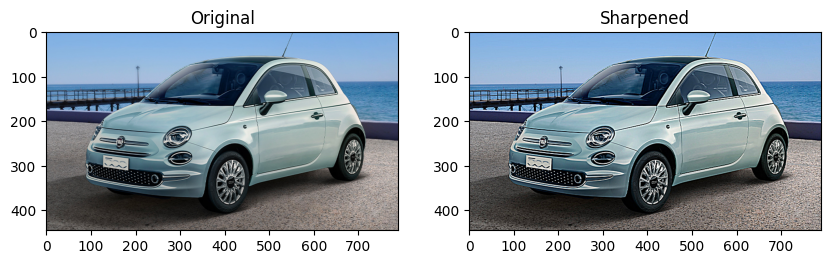

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt


def sharpen_image(image_path, blur_kernel_size=(7, 7), alpha=2,
                  beta=-1):
    image = cv.imread(image_path)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    blur = cv.blur(image, blur_kernel_size)
    sharp = cv.addWeighted(image, alpha,
                           blur, beta, 0)
    sharp_rgb = cv.cvtColor(sharp, cv.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('Original')

    plt.subplot(1, 2, 2)
    plt.imshow(sharp_rgb)
    plt.title('Sharpened')
    plt.show()

sharpen_image('example_images/fiat.jpg')

## Task 2-3

These 2 tasks embrace the process of training `opencv` model on a practical problem - passport photo validation. I decided not to reinvent the wheel and made use of the `YOLO` model (in particular `yolov8s`) in pair with `opencv` to solve this problem. The dataset contained only 50 images (250 * 250) initially, therefore I increased it to approximately 400 images. Before feeding them to the model to train it was necessary to perform certain image processing.

The main challenge was to identify the position of people on each image by recording their face and eye positions. For that I used `makesense.ai` tool which gave the opportunity to label the images in a convenient way so that yolo could process it. The labels of an image looked like this for example:

```
0 0.511905 0.468045 0.352130 0.552632
1 0.583333 0.457393 0.119048 0.065163
1 0.412907 0.436090 0.111529 0.060150
```

The first number represents the class the object in the image belongs to (0 for the face and 1 for the eye). The following numbers are the normalized border coordinates of the boxes embracing the objects.

With that having been done I trained the model by shuffling the whole dataset (images and their labels) and feeding it to the yolo model. The number of epochs was set to 50 in order to preserve computational power and time. The dataset was split using 70/30 ratio for training and validation respectively. The code implementation is presented in the following cell.

In [ ]:
import os
import random
from ultralytics import YOLO


IMAGES_FOLDER = "opencv_images"
TRAIN_DATASET_FILE = os.path.join(IMAGES_FOLDER, "train.txt")
VALIDATION_DATASET_FILE = os.path.join(IMAGES_FOLDER, "validation.txt")

images = [f for f in os.listdir(IMAGES_FOLDER) if f.endswith(('.jpg', '.png'))]
random.shuffle(images)

split_index = int(0.7 * len(images))
train_data = images[:split_index]
validation_data = images[split_index:]


def write_split(file_list, output_file):
    with open(output_file, "w") as f:
        for image_name in file_list:
            f.write(os.path.join(IMAGES_FOLDER, image_name) + "\n")


write_split(train_data, TRAIN_DATASET_FILE)
write_split(validation_data, VALIDATION_DATASET_FILE)

model = YOLO("yolov8s.pt")

model.train(
    data="data.yml",
    epochs=50,
    imgsz=256,
    batch=16,
    workers=4,
    name="passport_validation_model"
)

Some results of the training process are presented in the following image. It can be easily observed that during the training and validation processes the loss in identifying the object boxes and classes is tending to a very low value and the precision of the model, on the other hand, tends to values equal to 1. Summing up, the model had trained very well and demonstrated great results even though the number of epochs might have been too small.

![YOLO Training Results](results/runs/detect/passport_validation_model/results.png)

Further on, it was necessary to define the rules for validating passport images, beacuse the yolo model just gave us the opportunity to label new images (mark the face and eye positions). For that I decided to implement the rules presented in the conditions of the laboratory work itself. Here is the breakdown of each of them (the `is_valid_for_passport` method calculates the final result of the validation using the rules and takes as the main parameter image annotations or labels - their format was mentioned earlier):
* The image should be `color` - for each pixel of it the values for R, G and B should be equal.
* The image should be in `portrait` or `square` orientation - width must be less than or equal to the width.
* There have to be only `2 eyes identified` in the image and the distance between them on the y-axis should be no more than 5 pixels (correct alignment).
* The image should contain a `single person` (1 face discovered).
* The `area of the person's head` should be valid (the ratio between the face area and the image area should be `between 0.1 and 0.4`).

The methods which implement the above mentioned rules are presented in the cell below.

In [ ]:
# do not run this cell
import cv2


def is_valid_for_passport(image_path, annotations):
    image = cv2.imread(image_path)

    if image is None:
        return False

    height, width, _ = image.shape

    image_is_valid_for_passport = is_color(image) and is_portrait_or_square(width, height) and \
        contains_single_person(annotations) and \
        has_correctly_aligned_eyes(height, annotations) and \
        has_valid_head_area(width, height, annotations)

    return image_is_valid_for_passport


def is_color(image):
    if (image[..., 0] == image[..., 1]).all() and (image[..., 1] == image[..., 2]).all():
        print("Image is not in color")
        return False

    return True


def is_portrait_or_square(width, height):
    if width > height:
        print("Image is not in portrait orientation")
        return False

    return True


def has_correctly_aligned_eyes(height, annotations, eye_distance_threshold=5):
    eyes = [ann for ann in annotations if ann[0] == 1]

    if len(eyes) == 2:
        eye_y_coords = [int(eye[2] * height) for eye in eyes]

        if abs(eye_y_coords[0] - eye_y_coords[1]) > eye_distance_threshold:
            print("Eyes are not correctly aligned")
            return False

        return True
    else:
        print("Image does not contain two eyes")
        return False


def contains_single_person(annotations):
    faces = [ann for ann in annotations if ann[0] == 0]

    if len(faces) != 1:
        print("Image does not contain a single person")
        return False

    return True


def has_valid_head_area(width, height, annotations, head_area_lower_threshold=0.1,
                        head_area_upper_threshold=0.4):
    faces = [ann for ann in annotations if ann[0] == 0]

    face = faces[0]
    face_area = (face[3] * height) * (face[4] * width)
    image_area = height * width
    face_area_ratio = face_area / image_area

    if not (head_area_lower_threshold <= face_area_ratio <= head_area_upper_threshold):
        print("Head area is not within valid range")
        return False

    return True

Here are the examples of how the resulting yolo + opencv model identifies valid and invalid images:

![valid_photo](example_images/valid_photo.png) ![invalid_photo](example_images/invalid_photo.png)

## Task 4-5

In order to train the pure CNN model I first had to increase the number of images in the dataset and label them in the following format:

```
ImageName,Label
0.jpg,False
1.jpg,False
10.jpg,False
```

The process of labelling was optimized by creating a script which displayed one image at a time and gave the opportunity to either validate or invalidate it. The whole version of the script is presented in the next cell. Moreover, before training the CNN model I apllied several transforms to each image using the `ImageDataGenerator` (the whole CNN training process is explained further).

In [ ]:
import os
import csv
from PIL import Image
import matplotlib.pyplot as plt


IMAGES_FOLDER = './tensorflow_images'
IMAGE_LABELS = './tensorflow_images/labels.csv'


def label_images():
    print("Enter y/n for each image whether it is suitable for passport or not.\n")

    with open(IMAGE_LABELS, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['ImageName', 'Label'])

        for image_name in os.listdir(IMAGES_FOLDER):
            if image_name.endswith(('.jpg', '.png')) is False:
                continue

            image_path = os.path.join(IMAGES_FOLDER, image_name)

            image = Image.open(image_path)

            plt.imshow(image)
            plt.axis('off')
            plt.show(block=False)

            user_input = input(f"{image_name}: ")
            image_status = True if user_input.lower() == 'y' else False

            writer.writerow([image_name, image_status])

            plt.close()


if __name__ == "__main__":
    label_images()

And now it is time to discuss the CNN architecture itself. The whole model was implemented using `tensorflow` and `keras` modules. The CNN consumed images of size 128*128, therefore they were initially rescaled. At first, the images were processed by 3 consecutive `convolution layers` with decreasing kernel size and increasing number of filters. After each of the layers there was a `max pooling layer`. It basically downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window for each channel of the input. Then it was necessary to feed the resulting data to the `dense` layer by flattening the results first. The dense layer main task is to prepare the data obtained from the previous layers for classification. Finally, I performed the `dropout` to avoid overfitting by removing half of random activated neurons and introduced the last dense layer for final classification.

It is also important to explain the use of `activation functions` in each layer (`relu` and `sigmoid`). The former one was utilized in all of the layers except the last, because of being very efficient when training deep learning models, especially when dealing with `vanishing gradient problem` (it is a phenomenon that occurs during the training of deep neural networks, where the gradients that are used to update the network become extremely small as they are backpropogated from the output layers to the earlier layers). The latter one, on the other hand, was used to obtain binary classification in the last dense layer. `Sigmoid` is very similar to another activation function `softmax` which works for multiple classification and generates probability distribution for each of the input values.

With that being clarified, below is the implementation of the CNN training process.

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split


IMAGES = './tensorflow_images'
IMAGE_LABELS = './tensorflow_images/labels.csv'

data = pd.read_csv(IMAGE_LABELS)
data['Label'] = data['Label'].astype(str)

train_data, validation_data = train_test_split(
    data, test_size=0.3, random_state=42, shuffle=True)

train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255).flow_from_dataframe(
        dataframe=train_data,
        directory=IMAGES,
        x_col="ImageName",
        y_col="Label",
        target_size=(128, 128),
        class_mode="binary",
        batch_size=32,
        shuffle=True,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
)

validation_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255).flow_from_dataframe(
        dataframe=validation_data,
        directory=IMAGES,
        x_col="ImageName",
        y_col="Label",
        target_size=(128, 128),
        class_mode="binary",
        batch_size=32,
        shuffle=True,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(48, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_data_generator,
    validation_data=validation_data_generator,
    epochs=50,
    callbacks=[early_stopping],
)

print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

model.save('./models/face_detection_cnn.keras')

Next are presented the CNN training results. Because of the relatively small dataset they are not great but these are the best results that I managed to obtain. I tried to apply regularization, change the number of filters in each layer and add more convolution layers but it led either to a strong overfitting on the training dataset or to both training and validation accuracy being less than 0.5. It is worth mentioning that I did not run the model for the whole number of epochs. Instead I added an early stopping callback in order to stop training if the validation loss stopped improving.

![cnn_results](example_images/cnn_results.png)

## Task 6-7

In order to compare the performance of the yolo and tensorflow CNN models I formed another dataset of approximately 50 images (the models were not familiar with them). Then I labelled them just as I did for the CNN model training using a csv file with the following format:

```
ImageName,Label
0.jpg,False
1.jpg,False
10.jpg,False
```

I ran the prediction methods for both of the models and compared the results with the predefined labels, using the ratio between the number of correctly identified images and the total number of them. The only difficulty was to obtain the labels from the yolo model. Unlike the CNN which provides binary classification when making predictions, yolo required further image annotations processing using the passport photo validation methods. The code and the results of each model can be examined further. For the yolo model it can be observed that in case of invalid images the program outputs the reason why the model made that specific choice.

In [9]:
import pandas as pd
import tensorflow as tf
import cv2
import os
import numpy as np
from yolo_passport_validation import is_valid_for_passport
from ultralytics import YOLO


IMAGES = './test_dataset/images'
IMAGE_LABELS = './test_dataset/labels.csv'

data = pd.read_csv(IMAGE_LABELS)
data['Label'] = data['Label'].astype(str)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255).flow_from_dataframe(
        dataframe=data,
        directory=IMAGES,
        x_col="ImageName",
        y_col="Label",
        target_size=(128, 128),
        class_mode="binary",
        batch_size=32,
        shuffle=True,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
)

cnn_model = tf.keras.models.load_model('./models/face_detection_cnn.keras')
cnn_predictions = cnn_model.predict(test_generator, verbose=1)
cnn_predictions = (cnn_predictions > 0.5).astype(int)

yolo_model = YOLO('./models/face_detection_yolo.pt')
yolo_predictions = []

for i in range(len(data)):
    image_path = os.path.join(IMAGES, data['ImageName'][i])
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    results = yolo_model.predict(image_path)
    annotations = []

    for box in results[0].boxes:
        class_id = int(box.cls.item())
        class_name = results[0].names[class_id]

        x_center, y_center, bbox_width, bbox_height = box.xywh.numpy().flatten()

        x_center_normalized = x_center / width
        y_center_normalized = y_center / height
        bbox_width_normalized = bbox_width / width
        bbox_height_normalized = bbox_height / height

        annotations.append((class_id, x_center_normalized, y_center_normalized,
                           bbox_width_normalized, bbox_height_normalized))

    is_valid = is_valid_for_passport(image_path, annotations)
    yolo_predictions.append(int(is_valid))

true_labels = test_generator.labels
cnn_correct_predictions = np.sum(cnn_predictions.flatten() == true_labels)
yolo_correct_predictions = np.sum(np.array(yolo_predictions) == true_labels)

cnn_accuracy = cnn_correct_predictions / len(true_labels)
yolo_accuracy = yolo_correct_predictions / len(true_labels)

print(f"Tensorflow CNN Test Accuracy: {cnn_accuracy:.3f}")
print(f"YOLO Test Accuracy: {yolo_accuracy:.3f}")

Found 51 validated image filenames belonging to 2 classes.


c:\Users\User\Desktop\FIA_Labs\Lab5_ImageProcessing\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step

image 1/1 c:\Users\User\Desktop\FIA_Labs\Lab5_ImageProcessing\test_dataset\images\0.jpg: 256x256 1 face, 2 eyes, 93.1ms
Speed: 2.0ms preprocess, 93.1ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 c:\Users\User\Desktop\FIA_Labs\Lab5_ImageProcessing\test_dataset\images\1.jpg: 256x256 1 face, 2 eyes, 71.2ms
Speed: 1.6ms preprocess, 71.2ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 256)
Eyes are not correctly aligned

image 1/1 c:\Users\User\Desktop\FIA_Labs\Lab5_ImageProcessing\test_dataset\images\10.jpg: 256x256 1 face, 4 eyes, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 256)
Image does not contain two eyes

image 1/1 c:\Users\User\Desktop\FIA_Labs\Lab5_ImageProcessing\test_dataset\images\11.jpg: 256x256 1 face, 2 eyes, 68.9ms
Speed: 11.7ms preprocess, 68.9ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 c:\Users\Use

Although the results are not great, but they can be easily explained. The tensorflow CNN did not perform well because of the relatively small training and validation datasets. However, the test accuracy of this model is close to the validation accuracy which means that the model managed to generalize even on a small dataset. The reason why yolo did not show good results is the labelling process itself. The problem is that the model is much more precise when it comes to identifying face and eye positions in the image than my human eyes. Therefore, many images which were marked by me as valid for passport, were considered invalid by yolo for very accurate reasons. That is why, I think that the yolo model was trained very well and in fact shows decent performance (better than my eyes for sure).

Overall, in my opinion, using a CNN to perform image validation is a good choice. However, CNNs work better when it is required to extract some important details from images by using different filters on subsequent layers - so I would recommend to use them in this particular problem to identify human faces rather than perform immediate binary classification. One of the possible options to increase the performance of the pure CNN would be to choose a much larger dataset (by gathering more images and rescaling them, for instance). It could be also possible to collect images which are more suitable for the passport photo validation problem - many images contained faces from the crowd behind the person being photographed, which confused the model when making predictions. It would be better to make the background more neutral. Moreover, the people in the images were often captured in the middle of an action, that is why the shape of their faces was irregular and some objects might have appeared in front of them. This issue can be avoided for future improvements.

To sum up, using a two-step model with yolo and opencv would be a great option for real-life scenarios especially when the model possesses a large dataset of images with accurate labels.

## Conclusions:

In this laboratory work I got acquainted with different techniques of training CNN models when performing image analysis tasks. In particular I tried to solve the problem of validating photos for passport using CNN models and OpenCV. I familiarized myself with ready-to-use models like YOLO, played around with some basic methods from the opencv module in order to blur or sharpen the images and also developed my own CNN model using a combination of different convolutional layers. I learned how to prepare the dataset for model training, validation and testing and discovered some drawbacks of this process. Finally, I performed comparative analysis of the traditional CNN model and a combined YOLO + OpenCV model and drew some important conclusions from the obtained results. 

## Acknowledgements

In this laboratory work I was assisted by Arteom Kalamaghin from FAF-211. He helped me understand the process of training yolo model and offered me some images to complete the dataset.

## Bibliography:

1. https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html
2. https://www.opencvhelp.org/tutorials/image-processing/how-to-sharpen-image/
3. https://www.youtube.com/watch?v=RSXgyDf2ALo&ab_channel=MoisesdePauloDias
4. https://docs.ultralytics.com/modes/train/#usage-examples
5. https://docs.ultralytics.com/modes/predict/#usage-examples
6. https://keras.io/api/layers/
7. https://keras.io/api/layers/activations/
8. https://www.engati.com/glossary/vanishing-gradient-problem#:~:text=Vanishing%20gradient%20problem%20is%20a,layers%20to%20the%20earlier%20layers.